# Introduction

In the computer vision field, convolutional neural network (CNN) and its derivatives are major players in object detection out of images. Region-based CNN (R-CNN), fast R-CNN and faster R-CNN are developed for semantic segmentation, which classifies pixels in a image into distinc classes. Mask R-CNN, built on faster R-CNN, and U-Net are able to perform instance segmentation, i.e. determine if a pixel belongs to a specific object or not. 

Mask regional CNN (Mask R-CNN)(https://arxiv.org/abs/1703.06870) based on Faster R-CNN(https://arxiv.org/abs/1506.01497) performs object detection and outputs class labeling, rectangle box for each object and more binary masks for objects after implementation of a fully convolutional layer. U-Net employs convolutional and MaxPooling layers in the contracting state (feature extraction), and deconvolutional and pooling layers in the upsampling state to reach the original resolution(https://www.nature.com/articles/s41592-018-0261-2).

After discussion with my mentor Reza, I decided to use U-Net for my capstone project.

# Keras U-Net Cell Instance Segmentation

This notebook was adapted from Ammar Alhaj Ali's work in Sartorius-Cell Instance Segmentation Kaggle competetion. The kaggle dataset contains phase contrast microscopy images of several types of neuronal cells. Basically, the keras U-Net model is reproduced here and trained with the Sartorius dataset. Good luck! 

## Configure the Python environment

### load required modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import json
import cv2
import random

import tensorflow as tf
from tensorflow.keras.layers import concatenate

import keras 
from keras import backend as K 
from keras.models import Model 
from keras.layers import Input 
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
from tqdm import tqdm
from google.colab import drive
from sklearn.model_selection import train_test_split 

### mount google drive 

In [ ]:
GD_PATH = '/content/drive'

if os.path.exists(GD_PATH) :
  print ('Google drive has mounted.')
else : 
  drive.mount(GD_PATH)

# Path to Sartorius dataset
sartorius_path = '/content/drive/MyDrive/cellimages/sartorius'

Mounted at /content/drive


### general variables

In [ ]:
N_CHANNEL = 3
BATCH_SIZE = 16
HEIGHT = 256
WIDTH = 256
N_CLASSES = 3
RANDOM_STATE = 2023
TRAIN_IMAGE_PATH = os.path.join(sartorius_path, 'train')
TEST_IMAGE_PATH = os.path.join(sartorius_path, 'test')

### some functions

In [ ]:
def rle_decode(mask_rle, dimension, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(dimension[0] * dimension[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(dimension)


def build_masks(labels, dimension):
    '''Usually mask image'''
    
    mask = np.zeros(dimension, dtype=np.float32)
    for label in labels :
        _mask = rle_decode(label, dimension, color=1)
        mask = np.maximum(mask, _mask)
    return mask


def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (len(rle)==0): 
        return np.zeros((256,256) ,dtype=np.uint8)
    
    height= 520
    width = 704
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

## Data pipeline

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    '''Generates data for Keras'''
    def __init__(self, list_IDs, df, mode='fit', dim=(HEIGHT, WIDTH),
                 base_path=TRAIN_IMAGE_PATH, batch_size=BATCH_SIZE,
                 n_channels=N_CHANNEL, n_classes=N_CLASSES,
                 random_state=RANDOM_STATE, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        '''Retrieve image'''
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # Get image
        for i, ID in enumerate(list_IDs_batch):
            img_path = f"{self.base_path}/{ID}.png"
            img = self.__load_grayscale(img_path)
            # Store samples
            X[i,] = img 
        return X

    def __generate_y(self, list_IDs_batch):
        '''Restore image label'''
        # Initialization
        y = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        # Get annotations        
        for i, ID in enumerate(list_IDs_batch):
            image_df = self.df[self.df['id'] == ID]
            original_dims = (image_df.iloc[0,3], image_df.iloc[0,2])            
            rles = image_df['annotation'].values
            masks = build_masks(rles, original_dims)
            masks = cv2.resize(masks, self.dim)
            masks = np.expand_dims(masks, axis=-1)
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # resize image
        img = cv2.resize(img, self.dim)
        # normalize
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        return img

## Load dataset

In [ ]:
df = pd.read_csv(os.path.join(sartorius_path, 'train.csv'))
print (df.shape)
df.head()

(73585, 9)


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [ ]:
# Dataset pipeline
list_ID = df['id'].unique()
train_IDs, validation_IDs = train_test_split(list_ID, test_size=0.2, random_state=RANDOM_STATE)
train_gen = DataGenerator(
    train_IDs,
    df=df,
    batch_size=BATCH_SIZE,
    n_classes=N_CLASSES
)

validation_gen = DataGenerator(
    validation_IDs,
    df=df,
    batch_size=BATCH_SIZE,
    n_classes=N_CLASSES
)

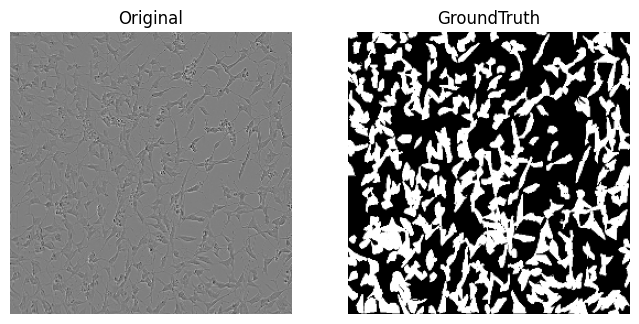

In [ ]:
i = random.randint(0, len(train_gen))
j = random.randint(0, BATCH_SIZE)

images, labels = train_gen[i]
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].imshow(images[j], cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(labels[j], cmap='gray')
axs[1].set_title('GroundTruth')
axs[1].axis('off')

plt.show()

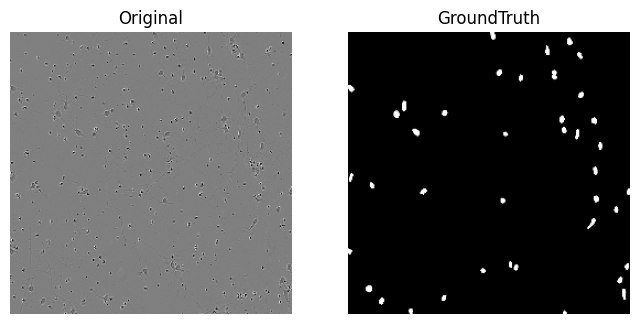

In [ ]:
i = random.randint(0, len(validation_gen))
j = random.randint(0, BATCH_SIZE)

images, labels = validation_gen[i]
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].imshow(images[j], cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(labels[j], cmap='gray')
axs[1].set_title('GroundTruth')
axs[1].axis('off')

plt.show()

## U-Net model

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-2r9sek91
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-2r9sek91
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable


model = Unet(
    'efficientnetb0',
    input_shape=(256, 256, 3),
    classes=3,
    activation='sigmoid',
    encoder_weights='imagenet'
)

#inp = Input(shape=(512, 640, 1))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)
#model = Model(inp, out, name=base_model.name)

model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,iou_coef,'accuracy']
) 
#bce_dice_loss binary_crossentropy

model.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                             

## Training model

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint

checkpoint_path = "training_5/cp-{epoch:04d}.ckpt"
checkpoint_path = os.path.join(sartorius_path, checkpoint_path)

EPOCHS = 50
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)


history = model.fit(
    train_gen,
    validation_data=validation_gen,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.8156 - dice_coef: 0.2765 - iou_coef: 0.1335 - accuracy: 0.0469
Epoch 1: val_loss improved from inf to 1.06030, saving model to /content/drive/MyDrive/cellimages/sartorius/training_5/cp-0001.ckpt
30/30 [==============================] - 151s 3s/step - loss: 0.8156 - dice_coef: 0.2765 - iou_coef: 0.1335 - accuracy: 0.0469 - val_loss: 1.0603 - val_dice_coef: 0.1714 - val_iou_coef: 0.0853 - val_accuracy: 0.0457
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.4744 - dice_coef: 0.4789 - iou_coef: 0.2366 - accuracy: 0.0478
Epoch 2: val_loss improved from 1.06030 to 0.80813, saving model to /content/drive/MyDrive/cellimages/sartorius/training_5/cp-0002.ckpt
30/30 [==============================] - 78s 2s/step - loss: 0.4744 - dice_coef: 0.4789 - iou_coef: 0.2366 - accuracy: 0.0478 - val_loss: 0.8081 - val_dice_coef: 0.1147 - val_iou_coef: 0.0476 - val_accuracy: 0.0076
Epoch 3/50
30/30 [=================

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(sartorius_path, 'history_05.csv'))

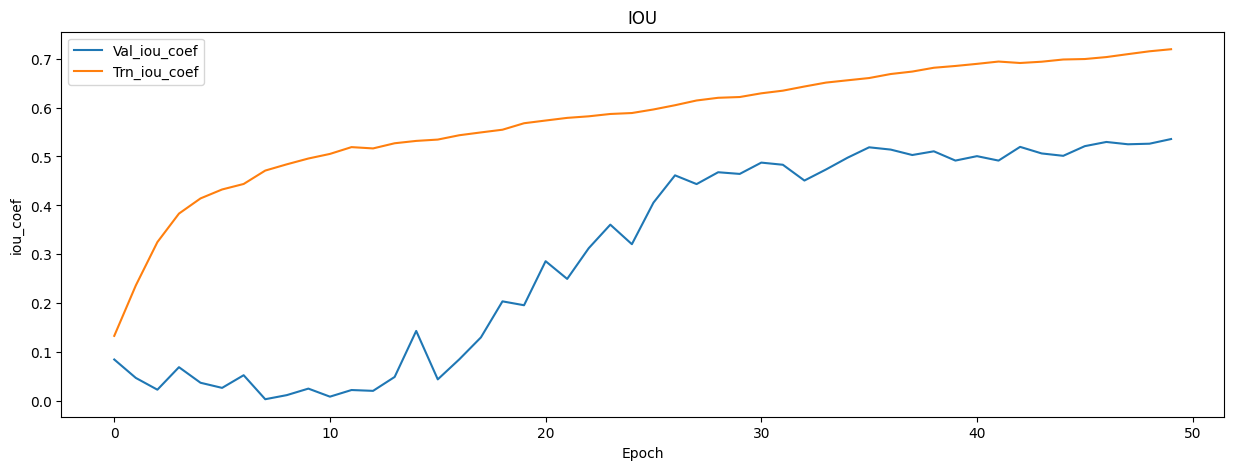

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend(); 
plt.show()

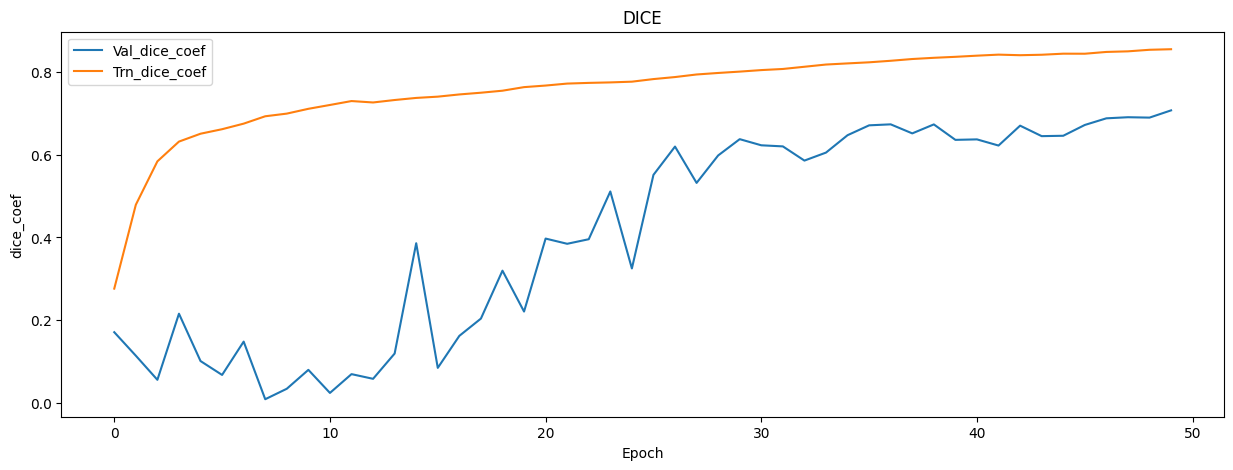

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
plt.show()

In [ ]:
# Save the model
model.save(os.path.join(sartorius_path, 'unet_model_5.h5'))

## Predict

In [ ]:
import glob

image_names = glob.glob(os.path.join(sartorius_path, 'test', '*'))

test_images = np.empty((len(image_names), HEIGHT, WIDTH, N_CHANNEL))
for i, name in enumerate(image_names) : 
  image = cv2.imread(name, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (HEIGHT, WIDTH))
  image = image.astype(np.float32) / 255. 
  image = np.expand_dims(image, axis=-1)

  test_images[i, ] = image

In [ ]:
test_images.shape

(3, 256, 256, 3)

In [ ]:
predicted = model.predict(test_images, batch_size=3)

1/1 [==============================] - 2s 2s/step


In [ ]:
predicted.shape

(3, 256, 256, 3)

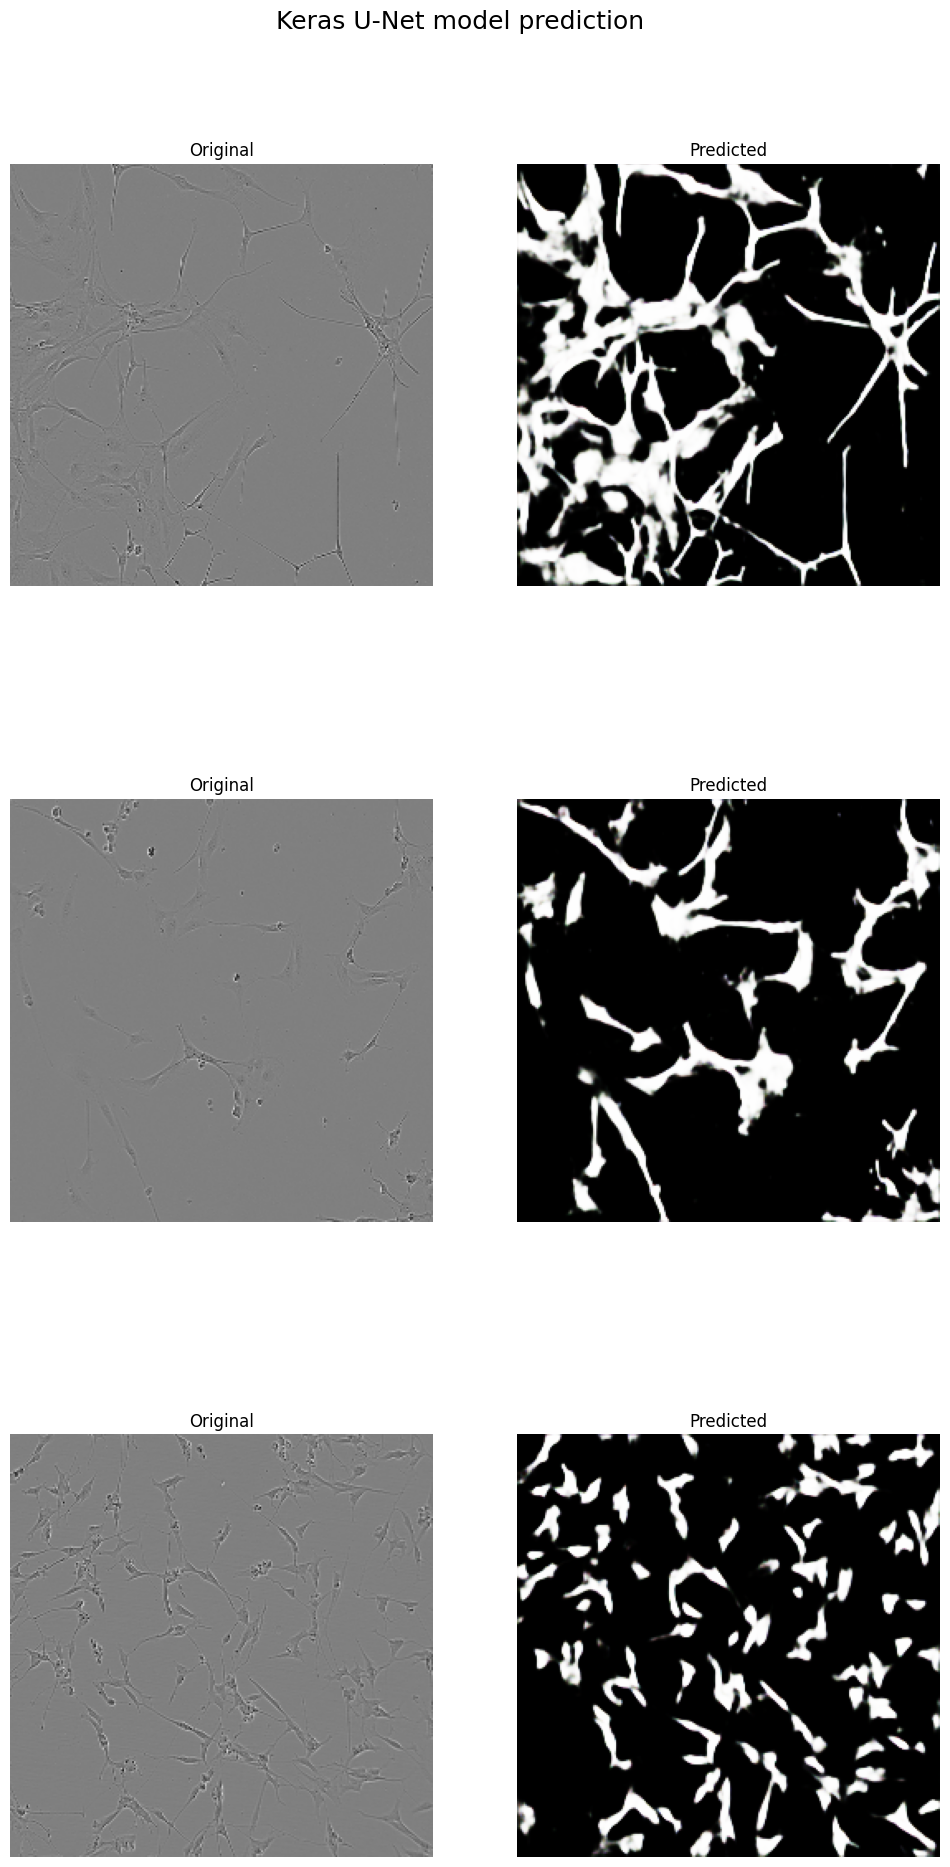

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 22))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Keras U-Net model prediction", fontsize=18, y=0.95)

for i, (original, prediction) in enumerate(zip(test_images, predicted)):
  # Original image
  axs[i, 0].imshow(original)
  axs[i, 0].axis('off')
  axs[i, 0].set_title('Original')
  # Model predicted
  axs[i, 1].imshow(prediction)
  axs[i, 1].axis('off')
  axs[i, 1].set_title('Predicted')

plt.show()

# Load saved models and test it

In [ ]:
saved_model = tf.keras.models.load_model(os.path.join(sartorius_path, 'unet_model_5.h5'),
                                         custom_objects=None,
                                         compile=False,
                                         options=None)

saved_model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,iou_coef,'accuracy']
) 

saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                                )                                                             